Setups and Imports

In [ ]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import random

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs_trained), h.history['accuracy'], label='Training')
    plt.plot(range(epochs_trained), h.history['val_accuracy'], label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs_trained), h.history['loss'], label='Training')
    plt.plot(range(epochs_trained), h.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    plt.matshow(cm, cmap=plt.cm.RdYlGn)
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Importing Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/DATA_2.csv', encoding='ISO-8859-1') # Replace 'MyDrive' with your Google Drive folder if necessary
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Data extraction function
def get_tweet(data):
    # Ensure no NaN in 'Review' or 'Sentiment' and convert to string
    data = data.dropna(subset=['Review', 'Sentiment'])
    tweets = data['Review'].astype(str).tolist()
    labels = data['Sentiment'].tolist()
    return tweets, labels

Tokenizer

In [ ]:
maxlen = 50
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<UNK>')
train_tweets, train_labels = get_tweet(train_data)
tokenizer.fit_on_texts(train_tweets)


In [ ]:
print(train_tweets[4])

I watched it at movie theatre, this movie deserve each penny. Cinematic and camera effects are superb


In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=maxlen, padding='post', truncating='post'
    )
    return padded

In [ ]:
classes = sorted(set(train_labels))  # Ensure consistent ordering
class_to_index = {c: i for i, c in enumerate(classes)}
index_to_class = {i: c for i, c in enumerate(classes)}
names_to_ids = lambda labels: np.array([class_to_index[x] for x in labels])

In [ ]:
tokenizer.texts_to_sequences([train_tweets[4]])


[[3,
  106,
  11,
  50,
  12,
  818,
  6,
  12,
  1072,
  591,
  7762,
  701,
  4,
  1250,
  843,
  30,
  1441]]

In [ ]:
train_tweets[4]


'I watched it at movie theatre, this movie deserve each penny. Cinematic and camera effects are superb'

Padding and Truncating Sequences

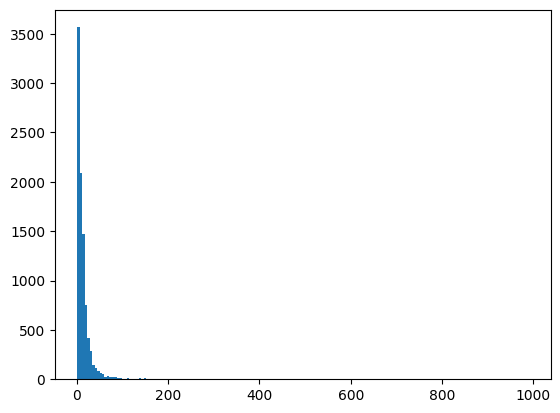

In [ ]:
lengths = [len(t.split(' ')) for t in train_tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()


Preparing the labels

In [ ]:
train_tweets, labels = get_tweet(train_data)
classes = set(labels)
print(classes)

{'Neutral', 'Positive', 'Negative'}


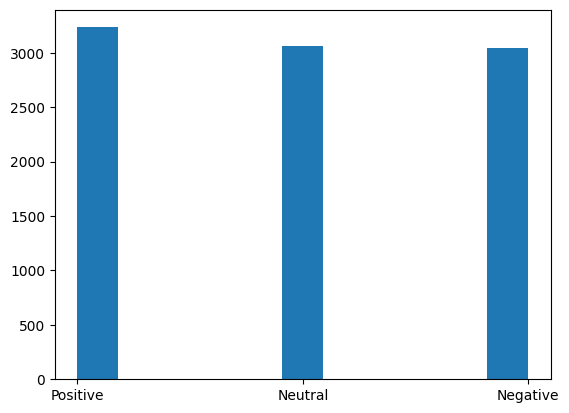

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'Neutral': 0, 'Positive': 1, 'Negative': 2}

In [ ]:
index_to_class

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [ ]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[6])

1


Creating the Model

In [ ]:
def process_data(tweets, labels):
    # Filter out empty or invalid tweets and keep labels aligned
    valid_pairs = [(t, l) for t, l in zip(tweets, labels) if t.strip()]
    if not valid_pairs:
        raise ValueError("No valid data after filtering")
    valid_tweets, valid_labels = zip(*valid_pairs)
    seq = get_sequences(tokenizer, valid_tweets)
    labels_array = names_to_ids(valid_labels)
    return seq, labels_array

In [ ]:
train_seq, train_labels = process_data(train_tweets, train_labels)
val_tweets, val_labels = get_tweet(val_data)
val_seq, val_labels = process_data(val_tweets, val_labels)
test_tweets, test_labels = get_tweet(test_data)
test_seq, test_labels = process_data(test_tweets, test_labels)

In [ ]:
print(f"Train samples: {len(train_seq)}, Train labels: {len(train_labels)}")
print(f"Val samples: {len(val_seq)}, Val labels: {len(val_labels)}")
print(f"Test samples: {len(test_seq)}, Test labels: {len(test_labels)}")

Train samples: 9339, Train labels: 9339
Val samples: 2002, Val labels: 2002
Test samples: 2002, Test labels: 2002


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 32, input_length=maxlen),

    # First BiLSTM with dropout
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    ),

    # Second BiLSTM with dropout
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)
    ),

    # Dense + Dropout + L2 Regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),  # Slightly higher dropout

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
]

In [ ]:
def names_to_ids(labels):
    """Converts a list of labels to a NumPy array of label IDs.
    Handles unknown labels by assigning a default label (e.g., 0).
    """
    # Use a default value (0) if label not found in class_to_index
    return np.array([class_to_index.get(x, 0) for x in labels])

# Ensure train_labels is a list before processing
train_tweets, labels = get_tweet(train_data)
train_labels = names_to_ids(labels) # Process labels before train_seq
train_seq, _ = process_data(train_tweets, train_labels)  # _ to ignore the second output

# Convert train_labels and val_labels to int64 after processing
train_labels = np.array(train_labels, dtype=np.int64)
val_labels = np.array(val_labels, dtype=np.int64)

h = model.fit(
    train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    batch_size=64,  # Increased batch size
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 107s 638ms/step - accuracy: 0.4236 - loss: 1.4652 - val_accuracy: 0.5764 - val_loss: 0.9522 - learning_rate: 0.0010
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 93s 640ms/step - accuracy: 0.6606 - loss: 0.8225 - val_accuracy: 0.7962 - val_loss: 0.5912 - learning_rate: 0.0010
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 140s 627ms/step - accuracy: 0.8599 - loss: 0.4505 - val_accuracy: 0.8282 - val_loss: 0.5270 - learning_rate: 0.0010
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 144s 642ms/step - accuracy: 0.9139 - loss: 0.3184 - val_accuracy: 0.8387 - val_loss: 0.5085 - learning_rate: 0.0010
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 91s 627ms/step - accuracy: 0.9273 - loss: 0.2659 - val_accuracy: 0.8307 - val_loss: 0.5367 - learning_rate: 0.0010
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 94s 641ms/step - accuracy: 0.9437 - loss: 0.2302 - val_accuracy: 0.8487 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 140s 630ms/step - accuracy:

Evaluating the Model

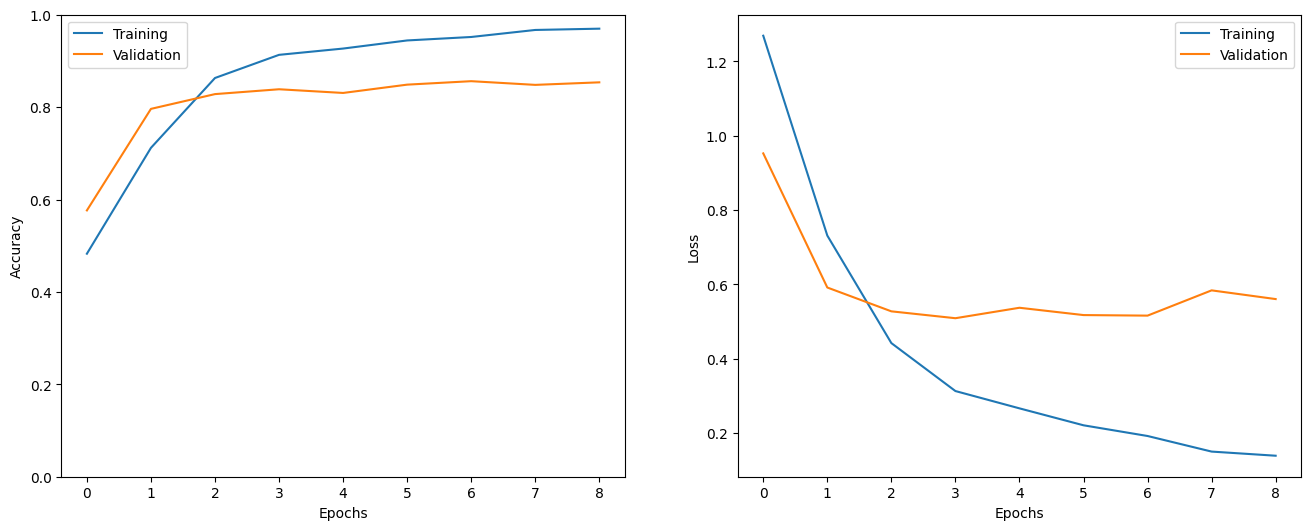

In [ ]:
show_history(h)

In [ ]:
test_loss, test_acc = model.evaluate(test_seq, test_labels)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8534 - loss: 0.4776
Test Accuracy: 0.8427, Test Loss: 0.4905


In [ ]:
i = random.randint(0, len(test_labels)-1)
print('Sentence: ',test_tweets[i]) # Changed test_tweet to test_tweets
print('Emotion: ',index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion: ',pred_class)

Sentence:  Yup. Garbage.
Emotion:  Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion:  Neutral


In [ ]:
preds = model.predict(test_seq)
classes_x = np.argmax(preds, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step


In [ ]:
print(set(test_labels))
print(set(classes_x))
print(len(list(classes)))

{np.int64(0), np.int64(1), np.int64(2)}
{np.int64(0), np.int64(1), np.int64(2)}
3


<Figure size 800x800 with 0 Axes>

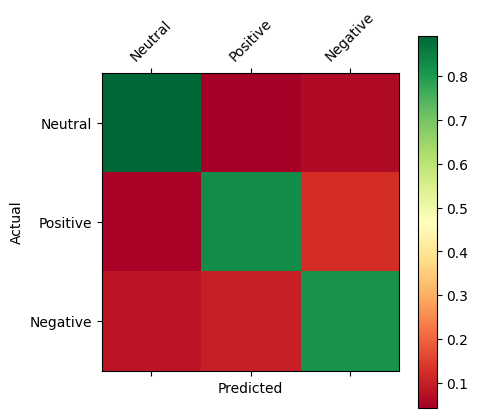

In [ ]:
show_confusion_matrix(test_labels, classes_x, list(classes))

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(test_labels, classes_x, target_names=list(classes)))

Classification Report:

              precision    recall  f1-score   support

     Neutral       0.86      0.88      0.87       653
    Positive       0.82      0.86      0.84       675
    Negative       0.85      0.79      0.82       674

    accuracy                           0.84      2002
   macro avg       0.84      0.84      0.84      2002
weighted avg       0.84      0.84      0.84      2002

